# Descriptives: attendance outcomes

Involves constructing the short-duration attendance outcomes

In [1]:
import warnings
from datetime import timedelta

import numpy as np
import pandas as pd
from plotnine import *

from suso.plotting_themes import standard_background, standard_background_rotatex_nojust
from suso.utils import PICKLE_PROTOCOL, here

warnings.filterwarnings("ignore")

In [2]:
DATA_DIR = here("data")
OUTPUT_DIR = here("output")

# 1. Read in data

In [3]:
attendance_eoy_wsuso = pd.read_pickle(DATA_DIR / "attendance_eoy_wsuso.pkl")
df_suso = pd.read_csv(DATA_DIR / "df_suso_merged.csv")

# 2: Summarise end of year attendance outcomes descriptively

- Construct
- Find descriptives

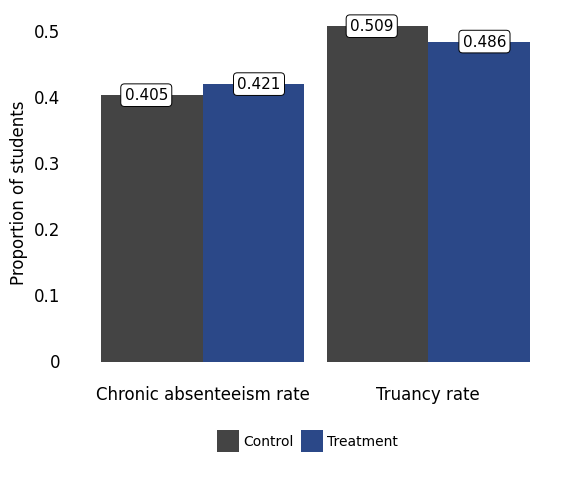

<ggplot: (335228191)>

In [4]:
absence_meanbytreat = attendance_eoy_wsuso.groupby("is_treatment")[
    "truant_indicator", "chronicabsent_indicator"
].mean()
absence_meanbytreat["treatment"] = absence_meanbytreat.index
absence_meanbytreat["treatment_descriptive"] = np.where(
    absence_meanbytreat.treatment == True, "Treatment", "Control"
)

absence_meanbytreat_long = pd.melt(
    absence_meanbytreat, id_vars=["treatment", "treatment_descriptive"]
)
absence_meanbytreat_long["variable_descriptive"] = np.where(
    absence_meanbytreat_long.variable == "truant_indicator",
    "Truancy rate",
    "Chronic absenteeism rate",
)
absence_meanbytreat_long["value_rounded"] = round(absence_meanbytreat_long.value, 3)

yearend_rates = (
    ggplot(
        absence_meanbytreat_long,
        aes(
            x="factor(variable_descriptive)",
            y="value",
            fill="treatment_descriptive",
            group="factor(treatment_descriptive)",
        ),
    )
    + geom_bar(position="dodge", stat="identity")
    + scale_fill_manual(values=("#444444", "#2B4888"))
    + geom_label(
        aes(x="factor(variable_descriptive)", y="value", label="value_rounded"),
        position=position_dodge(width=1),
        fill="white",
    )
    + standard_background
    + labs(fill="")
    + xlab("")
    + scale_fill_manual(values=("#444444", "#2B4888"))
    + ylab("Proportion of students")
    + theme(legend_position="bottom")
)

yearend_rates

In [5]:
ggsave(yearend_rates, OUTPUT_DIR / "yearend_rates.pdf", width=12, height=8)

# 3: Constructing the different short duration attendance outcomes

Two short duration attendance outcomes:

- "Observed delivery date": 
    - Tx group: delivery date if observed; 7 days post referral if missing (25% of sample)
    - Control group: find tx group member in their school with nearest referral date (before or after; so just minimize distance); assign them the delivery date of that minimum-distance treatment group members
    
- "Median delivery date":
    - For both groups, assign them sample median length of delivery (7 days post referral)


What counts as a delivery date? Two mailing statuses (relatively liberal; more conservative measure would only use USPS indicated delivered:

1. status == "USPS Indicated Delivered"
2. status == "Arrived at Recipient PO"

## 3.1: Find date to start clock for observed delivery date 

### 3.1.1 Load data on students, mailings, and referral date

- Mailings has multiple rows to correspond with different updates to the mailing status
- Job connects each mailing to a student id
- Students has their treatment status and whether they had valid info to be randomized
- df_suso (from ETO data/original data cleaning file) has information on referral date 

In [6]:
## get original enrolled date, school,
## record status and id from students
students = pd.read_csv(DATA_DIR / "students.csv")
students_topair = students.loc[
    students.id != 1, ["id", "school", "enrolled_date", "is_good_record"]
]
randomizer = pd.read_csv(DATA_DIR / "randomizer.csv")

## left join randomizer to students
students_topair_withtx = pd.merge(
    students_topair, randomizer, left_on="id", right_on="student_id", how="left"
)
students_topair_withtx_validrecords = students_topair_withtx.loc[
    students_topair_withtx.is_good_record == True
].copy()

## merge in referral date
refdate_tomerge = df_suso[["student_id", "referral_date"]]
students_topair_withtx_withrefdate = pd.merge(
    students_topair_withtx_validrecords, refdate_tomerge, on="student_id", how="left"
)


## merge in delivery date for tx group students
mailings = pd.read_csv(DATA_DIR / "mailings.csv")

## deduplicate as according to original script
mailings_deduped = mailings.sort_values(["job_id", "status_datetime"]).drop_duplicates(
    "job_id", keep="last"
)
jobs_deduped = (
    pd.read_csv(DATA_DIR / "jobs.csv")
    .sort_values(by=["student_id", "created_at"])
    .drop_duplicates("student_id", keep="last")
)

In [7]:
mailings_deduped_withstudentid = pd.merge(
    mailings_deduped[["job_id", "status", "status_datetime"]],
    jobs_deduped[["id", "student_id"]],
    left_on="job_id",
    right_on="id",
    how="inner",
)

## subset to two values indicating delivery status (restricting it to USPS only leaves about 300 students)
mailings_onlydelivery = mailings_deduped_withstudentid.loc[
    (
        (mailings_deduped_withstudentid.status == "USPS Indicated Delivered")
        | (mailings_deduped_withstudentid.status == "Arrived at Recipient PO")
    )
    & (mailings_deduped_withstudentid.student_id.notnull()),
    ["student_id", "status_datetime", "status"],
].copy()

### 3.1.2 Merge information on delivery back with treatment status to check missingness for tx group students



In [8]:
## merge the date onto the treatment status
allstudents_withdelivery = pd.merge(
    students_topair_withtx_withrefdate,
    mailings_onlydelivery,
    on="student_id",
    how="left",
)

allstudents_withdelivery.head()

print(
    str(
        allstudents_withdelivery.loc[
            (allstudents_withdelivery.is_treatment == True)
            & (allstudents_withdelivery.status_datetime.isnull())
        ].shape[0]
    )
    + " students out of "
    + str(
        allstudents_withdelivery.loc[
            (allstudents_withdelivery.is_treatment == True)
        ].shape[0]
    )
    + " treatment group members are missing a delivery date, or "
    + str(
        (
            allstudents_withdelivery.loc[
                (allstudents_withdelivery.is_treatment == True)
                & (allstudents_withdelivery.status_datetime.isnull())
            ].shape[0]
            / allstudents_withdelivery.loc[
                (allstudents_withdelivery.is_treatment == True)
            ].shape[0]
        )
        * 100
    )
    + " percent of the sample"
)

163 students out of 683 treatment group members are missing a delivery date, or 23.865300146412885 percent of the sample


### 3.1.3 Impute median delivery time for treatment students missing a delivery date and add flag for whether obs. versus imputed

- Purpose of flag is to later do sensitivity checks with the results

In [9]:
## first, convert to datetime and
## get proper date of referral or eligibility
allstudents_withdelivery["referral_date_dt"] = pd.to_datetime(
    allstudents_withdelivery.referral_date
)
allstudents_withdelivery["enrolled_date_dt"] = pd.to_datetime(
    allstudents_withdelivery.enrolled_date
)
allstudents_withdelivery["delivery_date_dt"] = pd.to_datetime(
    allstudents_withdelivery.status_datetime
)

## see whether date of referral = date of enrolled
allstudents_withdelivery["referral_same_enrolled"] = np.where(
    allstudents_withdelivery.referral_date_dt
    == allstudents_withdelivery.enrolled_date_dt,
    1,
    0,
)

## looked at students that have a different "referral date" than
## enrolled date-- most have the same (and enrolled means enrolled in suso
## rather than engaged by the cbo)
## for ones that differ, it's because they're missing a value
## for the referral date variable

## for rest of script, use enrolled_date as the
## date of referral

In [10]:
allstudents_withdelivery["time_to_delivery"] = (
    allstudents_withdelivery.delivery_date_dt
    - allstudents_withdelivery.enrolled_date_dt
)

median_delivery = allstudents_withdelivery["time_to_delivery"].describe()["50%"]
print("The median delivery time is: " + str(median_delivery))


## create indicator for which missing
allstudents_withdelivery["delivery_date_imputation_indicator"] = np.where(
    (allstudents_withdelivery.delivery_date_dt.isnull())
    & (allstudents_withdelivery.is_treatment == True),
    "treatment_imputed",
    np.where(
        (allstudents_withdelivery.delivery_date_dt.notnull())
        & (allstudents_withdelivery.is_treatment == True),
        "treatment_observed",
        "control",
    ),
)

The median delivery time is: 7 days 10:20:54


In [11]:
## for treatment observations missing a delivery date,
## add median time
allstudents_withdelivery["delivery_date_imputed"] = np.where(
    allstudents_withdelivery.delivery_date_imputation_indicator == "treatment_imputed",
    allstudents_withdelivery.enrolled_date_dt + median_delivery,
    allstudents_withdelivery.delivery_date_dt,
)

In [12]:
## clean the school string
## to remove the (k-8) etc
## because that causes issues
## later with string matching
allstudents_withdelivery[
    "school_cleaned"
] = allstudents_withdelivery.school.str.replace("\\(.*\\)$", "")

In [13]:
## separate groups
txstudents = allstudents_withdelivery.loc[
    allstudents_withdelivery.is_treatment == True
].copy()
controlstudents = allstudents_withdelivery.loc[
    allstudents_withdelivery.is_treatment == False
].copy()

## summarize
print(
    "There are "
    + str(len(controlstudents.student_id.unique()))
    + " control students to match with "
    + str(len(txstudents.student_id.unique()))
    + " tx students in order to assign delivery dates"
)

There are 652 control students to match with 683 tx students in order to assign delivery dates


### 3.1.4 assign control group students to treatment group student in their school with closest referral/eligibility date

In [14]:
## get control students who are missing a school
controlstudents_noschool_cantmatch = controlstudents.loc[
    (controlstudents.school.isnull()) | (controlstudents.school == "n.n")
].shape[0]
print(
    "For this version of outcome variable, "
    + str(controlstudents_noschool_cantmatch)
    + " control students cant be matched to tx student bc they're missing a school in the SUSO data (so can't be matched within a school)"
)
print("Later, might be able to look at OSSE data to find a school for these students")

For this version of outcome variable, 103 control students cant be matched to tx student bc they're missing a school in the SUSO data (so can't be matched within a school)
Later, might be able to look at OSSE data to find a school for these students


In [15]:
## subset to control students with ANY school
controlstudents_wschool = controlstudents.loc[
    (controlstudents.school.notnull()) & (controlstudents.school != "n.n")
]

##
print("After removing control group students missing a school, there are")
print(
    str(len(controlstudents_wschool.student_id.unique()))
    + " control students to match with "
    + str(len(txstudents.student_id.unique()))
    + " tx students in order to assign delivery dates"
)

## make sure that for those students, there are some
## tx group students with their school
print("-----------------------------------------------------------------------")
print(
    "Of those "
    + str(len(controlstudents_wschool.student_id.unique()))
    + " control group students, "
    + str(
        controlstudents_wschool[
            controlstudents_wschool.school.isin(txstudents.school)
        ].shape[0]
    )
    + " are in schools with at least 1 tx group student"
)

After removing control group students missing a school, there are
549 control students to match with 683 tx students in order to assign delivery dates
-----------------------------------------------------------------------
Of those 549 control group students, 549 are in schools with at least 1 tx group student


### 3.1.5 define function to do matching for the purposes of assigning control group students a delivery date

Function takes in:

- A particular control student
- Pool of tx students they could be matched with (use matching in the loose sense; not 1 to 1 but instead just assigning control students delivery date of the tx student in their school with the nearest referral date)

What it does:

- Subsets pool of treatment group students to those in the focal control student's school 
- Finds the referral dates for those treatment group students 
- Finds the referral date for the focal control group student
- Finds the treatment student referral date closest to the focal control student's referral date 
- Subsets to treatment students with that nearest referral date-- it might be multiple since multiple students can be referred on the same day
- Looks at the delivery date for those treatment students and finds two dates (using a version of the delivery date variable that contains the 75% observed delivery dates; 25% imputed to 7 days delivery dates)

    - Minimum delivery date
    - Maximum delivery date
    
Application: then apply using two pools of treatment group students

    - For main results: treatment students are in pool regardless of whether their delivery date was observed or imputed to be 7 days post-referral
    - For potential robustness later (don't currently use): treatment students are only in pool if we observe their delivery date
    
For now: code students to their minimum delivery date that comes from matching them with a student 

In [16]:
def find_inschool_matches(control_student, all_treatment_students):

    ## construct pool as tx students at same school as control
    controlschool = control_student.school_cleaned
    txpool = all_treatment_students[
        all_treatment_students.school_cleaned.str.match(controlschool) == True
    ].copy()

    ## for tx pool, create list of dates
    dates_tosearch_in = txpool.enrolled_date_dt.tolist()

    ## for control, get date
    date_tosearch = control_student.enrolled_date_dt

    ## nearest enrollment date
    nearest = min(dates_tosearch_in, key=lambda x: abs(x - date_tosearch))

    ## find the delivery info for that date
    ## and return in a dataframe with other info
    txpool_thatdate = txpool.loc[(txpool.enrolled_date_dt.isin([nearest]))]

    ## create dataframe with max and min
    summarize_matches = pd.DataFrame(
        {
            "student_id": control_student.student_id,
            "enrolled_date": control_student.enrolled_date_dt,
            "nearest_enrolled_tx": [nearest],
            "min_delivery_date": np.min(txpool_thatdate.delivery_date_imputed),
            "max_delivery_date": np.max(txpool_thatdate.delivery_date_imputed),
        }
    )

    ## return
    return summarize_matches

#### 3.1.5.1 Matching when we allow controls to be matched to treatment with imputed delivery date

In [17]:
## loop through control students (did loop rather than
## row-wise apply to allow for try except logic)
all_matches = []
for i in range(0, controlstudents_wschool.shape[0]):

    control_student = controlstudents_wschool.iloc[i]
    try:
        matches_forcontrol = find_inschool_matches(control_student, txstudents)
        all_matches.append(matches_forcontrol)
    except:
        pass

In [18]:
all_matches_df = pd.concat(all_matches)

## write to pickle
all_matches_df.to_pickle(
    DATA_DIR / "controlgroup_findingdeliverydate.pkl", protocol=PICKLE_PROTOCOL
)

In [19]:
print(
    "Out of "
    + str(len(controlstudents_wschool.student_id.unique()))
    + " control group students,"
    + " matched delivery date for the following when we allow observed or imputed delivery: "
    + str(all_matches_df.shape[0])
)

Out of 549 control group students, matched delivery date for the following when we allow observed or imputed delivery: 549


#### 3.1.5.2 Matching when we restrict matches to treatment w/ observed delivery date

In [20]:
txstudents_observed = txstudents.loc[
    txstudents.delivery_date_imputation_indicator == "treatment_observed"
].copy()

In [21]:
all_matches_observed = []
for i in range(0, controlstudents_wschool.shape[0]):

    control_student = controlstudents_wschool.iloc[i]
    try:
        matches_forcontrol_observed = find_inschool_matches(
            control_student, txstudents_observed
        )
        all_matches_observed.append(matches_forcontrol_observed)
    except:
        pass

In [22]:
all_matches_df_observed = pd.concat(all_matches_observed)

print(
    "Out of "
    + str(len(controlstudents_wschool.student_id.unique()))
    + " control group students,"
    + " matched delivery date for the following when we only allow observed delivery: "
    + str(all_matches_df_observed.shape[0])
)

## left join the two
new_colnames = [
    col + "_onlymatchwobserved" if "delivery" in col else col
    for col in all_matches_df_observed.columns
]
all_matches_df_observed.columns = new_colnames

all_matches_impute_or_observed = pd.merge(
    all_matches_df,
    all_matches_df_observed[
        [
            "student_id",
            "min_delivery_date_onlymatchwobserved",
            "max_delivery_date_onlymatchwobserved",
        ]
    ],
    on="student_id",
    how="left",
)

## for now, code final delivery date to the average of min and max delivery date
## when allowing pairing with treatment students regardless of whether they're delivery date
## is observed (75% of students) or imputed
all_matches_impute_or_observed[
    "final_delivery_date"
] = all_matches_impute_or_observed.min_delivery_date + (
    (
        all_matches_impute_or_observed.max_delivery_date
        - all_matches_impute_or_observed.min_delivery_date
    )
    / 2
)

Out of 549 control group students, matched delivery date for the following when we only allow observed delivery: 543


#### 3.1.6 Add back other two groups

- Students from control group not matched bc missing school (NA for all values)
- Treatment group students (NA for min and max; observed delivery date)

##### Control students missing a school in suso data (so cant be matched within a school)

In [23]:
empty_df = pd.DataFrame(
    {
        "nearest_enrolled_tx": [np.nan],
        "min_delivery_date": [np.nan],
        "max_delivery_date": [np.nan],
        "min_delivery_date_onlymatchwobserved": [np.nan],
        "max_delivery_date_onlymatchwobserved": [np.nan],
        "final_delivery_date": [np.nan],
    }
)

In [24]:
controlstudents_noschool_toadd = controlstudents.loc[
    (controlstudents.school.isnull()) | (controlstudents.school == "n.n"),
    ["student_id", "enrolled_date"],
]
controlstudents_noschool_toadd_wcols = pd.concat(
    [controlstudents_noschool_toadd, empty_df]
)

##### Treatment students

In [25]:
empty_df_tx = pd.DataFrame(
    {
        "nearest_enrolled_tx": [np.nan],
        "min_delivery_date": [np.nan],
        "max_delivery_date": [np.nan],
        "min_delivery_date_onlymatchwobserved": [np.nan],
        "max_delivery_date_onlymatchwobserved": [np.nan],
    }
)

In [26]:
txstudents_toadd = txstudents[["student_id", "enrolled_date", "delivery_date_imputed"]]

In [27]:
txstudents_toadd.columns = [
    "final_delivery_date" if col == "delivery_date_imputed" else col
    for col in txstudents_toadd.columns
]
txstudents_toadd_wcols = pd.concat([txstudents_toadd, empty_df_tx])

In [28]:
allstudents_withdeliverydate = pd.concat(
    [
        txstudents_toadd_wcols,
        controlstudents_noschool_toadd_wcols,
        all_matches_impute_or_observed,
    ],
    axis=0,
)
allstudents_withdeliverydate = allstudents_withdeliverydate[
    allstudents_withdeliverydate.student_id.notnull()
]

## 3.2. Find date to start clock for 7 days post-referral date

In [29]:
allstudents_withdeliverydate["enrolled_date_dt"] = pd.to_datetime(
    allstudents_withdeliverydate.enrolled_date
)

In [30]:
allstudents_withdeliverydate[
    "final_enrolled_plus7days"
] = allstudents_withdeliverydate.enrolled_date_dt + timedelta(days=7)

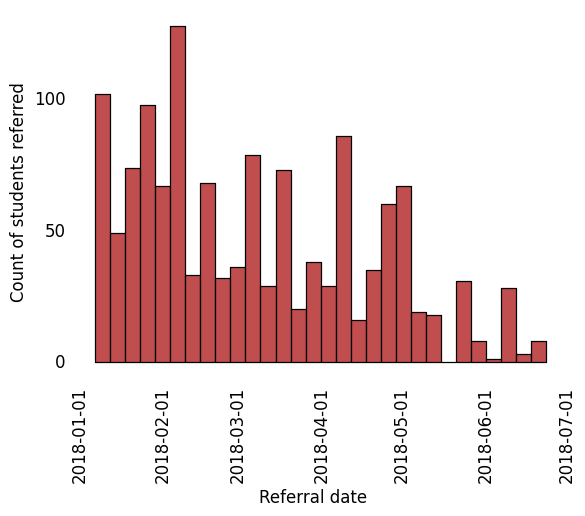

<ggplot: (335767257)>

In [31]:
(
    ggplot(allstudents_withdeliverydate, aes(x="enrolled_date_dt"))
    + geom_histogram(bins=30, color="black", fill="firebrick", alpha=0.8)
    + standard_background
    + theme(axis_text_x=element_text(angle=90))
    + ylab("Count of students referred")
    + xlab("Referral date")
)

# 4. Descriptives on absences at time of referral

### 4.1 Pull all time-varying attendance outcomes from larger data

In [32]:
## load cleaned attendance data
attendance_both_clean = pd.read_parquet(DATA_DIR / "attendance_both_clean.parquet")

## load lookup table
lookup_suso_attendance = pd.read_pickle(DATA_DIR / "suso_osse_lookup.pkl")

## different ID's (described in previous script)
susoids_ref_and_treat = list(
    set(lookup_suso_attendance.suso_id).intersection(
        set(df_suso.student_id[df_suso.is_treatment.notnull()])
    )
)
susoids_ref_or_treat = list(
    set(lookup_suso_attendance.suso_id).intersection(set(df_suso.student_id))
)

usis_ref_and_treat = lookup_suso_attendance.usi[
    lookup_suso_attendance.suso_id.isin(susoids_ref_and_treat)
]
usis_ref_or_treat = lookup_suso_attendance.usi[
    lookup_suso_attendance.suso_id.isin(susoids_ref_or_treat)
]

## subset to time varying outcomes
attendance_timevary = pd.merge(
    attendance_both_clean[
        [
            "AttendanceDate",
            "Attendance_Status_Desc",
            "Weekday_Name",
            "total_excusedorunexcused",
            "total_schooldays",
            "total_unexcused",
            "usi",
        ]
    ],
    lookup_suso_attendance[["suso_id", "usi", "type_of_match"]],
    on="usi",
    how="left",
)

### 4.2 Merge with delivery date info on the basis of suso id

In [33]:
## subset to those we have treatment info for and merge
attendance_timevary_withdeliv = pd.merge(
    attendance_timevary[attendance_timevary.suso_id.isin(susoids_ref_and_treat)],
    allstudents_withdeliverydate[
        allstudents_withdeliverydate.student_id.isin(susoids_ref_and_treat)
    ],
    left_on="suso_id",
    right_on="student_id",
    how="left",
)

## merge in treatment status
othervars_tomerge = attendance_eoy_wsuso[
    [
        "usi",
        "school_name",
        "is_treatment",
        "chronicabsent_indicator",
        "truant_indicator",
    ]
].copy()

attendance_timevary_toconstruct = pd.merge(
    attendance_timevary_withdeliv, othervars_tomerge, on="usi", how="left"
)

In [34]:
attendance_timevary_toconstruct["attendance_date_dt"] = pd.to_datetime(
    attendance_timevary_toconstruct.AttendanceDate
)

In [35]:
### Subset to absence count when referred
attendance_atenroll_subset = attendance_timevary_toconstruct.loc[
    attendance_timevary_toconstruct.enrolled_date_dt
    == attendance_timevary_toconstruct.attendance_date_dt
].copy()

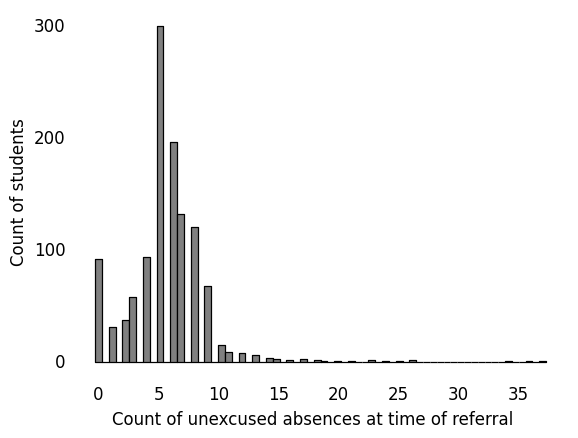

<ggplot: (335772832)>

In [36]:
### plot the unexcused absences at enrollment count
(
    ggplot(attendance_atenroll_subset, aes(x="total_unexcused"))
    + geom_histogram(fill="gray", color="black")
    + xlab("Count of unexcused absences at time of referral")
    + ylab("Count of students")
    + scale_x_continuous(breaks=(0, 5, 10, 15, 20, 25, 30, 35))
    + standard_background
)

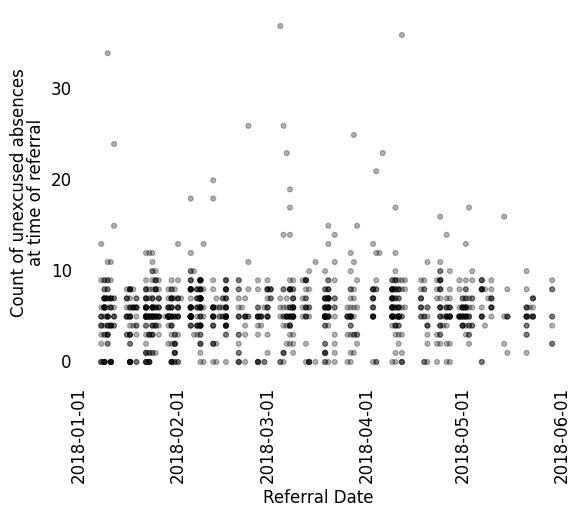

<ggplot: (335774172)>

In [37]:
(
    ggplot(attendance_atenroll_subset, aes(x="enrolled_date_dt", y="total_unexcused"))
    + geom_point(alpha=0.3)
    + ylab("Count of unexcused absences\nat time of referral")
    + xlab("Referral Date")
    + standard_background_rotatex_nojust
)

# 5. Construct absences that accrue during 2 calendar weeks beginning with the different clocks computed in section 3

## 5.1 Function


Takes in:

- data: pd.DataFrmae
- start_date_varname: Name of the variable that starts the clock (e.g., median versus observed delivery)
- time_increment: how many days we want to add to that start date-- passed to timedelta which adds that duration and rounds to nearest day
- clock_name: string that helps us subset to the correct variables by using the suffix that indicates which clock corresponds to which var
- date_cols: columns that give us information about referral and delivery dates

Returns:

- Dataframe with three differences in that time interval: unexcused abs., excused or unexcused abs., school attendance days

In [38]:
def construct_wideformat_absencecounts(
    data, start_date_varname, time_increment, clock_name, date_cols
):

    data["end_" + clock_name] = data[start_date_varname] + timedelta(
        days=time_increment
    )

    ## absences and school days at start
    cols_topull = [
        "usi",
        "suso_id",
        "AttendanceDate",
        "total_excusedorunexcused",
        "total_schooldays",
        "total_unexcused",
    ]
    absence_count_start = data.loc[
        data[start_date_varname] == attendance_timevary_toconstruct["AttendanceDate"],
        cols_topull,
    ]
    cols_toshield = ["usi", "suso_id"] + date_cols
    absence_count_start.columns = [
        col + "_start" + clock_name if col not in cols_toshield else col
        for col in absence_count_start.columns
    ]

    ## absences and school days at end
    absence_count_end = data.loc[
        data["end_" + clock_name] == data["AttendanceDate"],
        [
            "usi",
            "AttendanceDate",
            "total_excusedorunexcused",
            "total_schooldays",
            "total_unexcused",
        ],
    ]
    absence_count_end.columns = [
        col + "_end" + clock_name if col not in ["usi"] else col
        for col in absence_count_end.columns
    ]

    ## putting them together
    static_cols = ["usi"] + date_cols
    all_usis = pd.merge(
        data[static_cols].drop_duplicates(), absence_count_start, on="usi", how="left"
    )

    absence_diff = pd.merge(all_usis, absence_count_end, on="usi", how="left")

    ## calculate differences
    absence_diff["diff_excusedorunexcused_" + clock_name] = (
        absence_diff["total_excusedorunexcused_end" + clock_name]
        - absence_diff["total_excusedorunexcused_start" + clock_name]
    )
    absence_diff["diff_unexcused_" + clock_name] = (
        absence_diff["total_unexcused_end" + clock_name]
        - absence_diff["total_unexcused_start" + clock_name]
    )
    absence_diff["diff_schooldays_" + clock_name] = (
        absence_diff["total_schooldays_end" + clock_name]
        - absence_diff["total_schooldays_start" + clock_name]
    )

    return absence_diff

## 5.2: counts starting at median delivery date clock

In [39]:
date_cols = [
    col
    for col in attendance_timevary_toconstruct.columns
    if "delivery" in col or "enrolled" in col
]
date_cols

['enrolled_date',
 'final_delivery_date',
 'nearest_enrolled_tx',
 'min_delivery_date',
 'max_delivery_date',
 'min_delivery_date_onlymatchwobserved',
 'max_delivery_date_onlymatchwobserved',
 'enrolled_date_dt',
 'final_enrolled_plus7days']

In [40]:
median_delivery_results = construct_wideformat_absencecounts(
    attendance_timevary_toconstruct,
    "final_enrolled_plus7days",
    14,
    "mediandelivery",
    date_cols,
)

In [41]:
## left join with treatment status indicator and visualize results
cols_tojoin = [
    col
    for col in attendance_eoy_wsuso.columns
    if col not in "enroll_date" and col not in "suso_id"
]  # remove SCHOOL enrollment date column
## to avoid confusion w/ suso enrollment date

attendance_winitialshort = pd.merge(
    attendance_eoy_wsuso[cols_tojoin], median_delivery_results, on="usi", how="inner"
)

In [42]:
pd.options.display.float_format = "{:.2f}".format

## plot differences in unexcused by group
attendance_winitialshort["treatment_descriptive"] = np.where(
    attendance_winitialshort.is_treatment == True, "Treatment", "Control"
)
unex_itt = (
    ggplot(
        attendance_winitialshort,
        aes(x="diff_unexcused_mediandelivery", fill="factor(treatment_descriptive)"),
    )
    + geom_histogram(bins=10, color="black")
    + standard_background
    + facet_wrap("~treatment_descriptive")
    + scale_fill_manual(values=("#444444", "#2B4888"))
    + labs(fill="")
    + guides(fill=False)
    + theme(legend_position=(0.8, 0.7))
    + scale_x_continuous(breaks=np.arange(0, 9, 1))
    + xlab(
        "Additional unexcused absences:\nstart date: one calendar week post-referral\nend date: two calendar weeks after that"
    )
)


both_itt = (
    ggplot(
        attendance_winitialshort,
        aes(
            x="diff_excusedorunexcused_mediandelivery",
            fill="factor(treatment_descriptive)",
        ),
    )
    + geom_histogram(bins=10, color="black")
    + standard_background
    + facet_wrap("~treatment_descriptive")
    + scale_fill_manual(values=("#444444", "#2B4888"))
    + labs(fill="")
    + guides(fill=False)
    + theme(legend_position=(0.8, 0.7))
    + scale_x_continuous(breaks=np.arange(0, 9, 1))
    + xlab(
        "Additional excused AND unexcused absences:\nstart date: one calendar week post-referral\nend date: two calendar weeks after that"
    )
)

ggsave(unex_itt, OUTPUT_DIR / "unex_itt.pdf", width=12, height=8)

ggsave(both_itt, OUTPUT_DIR / "both_itt.pdf", width=12, height=8)

#### 5.2.1  diagnosing students who are missing data  on these short-term attendance outcomes

In [43]:
## 9 students missing time-varying outcome
## see that most of them were erroneously
## marked as enrolled in suso in august
students_missing_timevary = attendance_winitialshort.loc[
    attendance_winitialshort.diff_unexcused_mediandelivery.isnull()
].copy()
students_missing_timevary[
    [
        "usi",
        "is_treatment",
        "total_unexcused_startmediandelivery",
        "total_unexcused_endmediandelivery",
        "final_enrolled_plus7days",
    ]
    + date_cols
]

print(
    "There are "
    + str(students_missing_timevary.shape[0])
    + " students missing these short-term attendance outcomes"
)

## for the usis in original data, plot
## attendance dates
students_missing_timevary_dates = attendance_timevary_toconstruct.loc[
    attendance_timevary_toconstruct.usi.isin(students_missing_timevary.usi),
    ["AttendanceDate", "enrolled_date_dt", "usi", "final_enrolled_plus7days"],
]

## for each, subset to 1 week before and 3 weeks after for better graph
students_missing_timevary_dates_smallerwindow = students_missing_timevary_dates[
    (
        students_missing_timevary_dates.AttendanceDate
        >= students_missing_timevary_dates.final_enrolled_plus7days - timedelta(days=14)
    )
    & (
        students_missing_timevary_dates.AttendanceDate
        <= students_missing_timevary_dates.final_enrolled_plus7days + timedelta(days=21)
    )
].copy()


students_missing_timevary_dates_smallerwindow[
    "twoweeks_later"
] = students_missing_timevary_dates_smallerwindow.final_enrolled_plus7days + timedelta(
    days=14
)

There are 9 students missing these short-term attendance outcomes


In [44]:
%%capture

(
    ggplot(students_missing_timevary_dates_smallerwindow, aes(x="AttendanceDate"))
    + geom_histogram(bins=40, fill="gray", alpha=0.5, color="black")
    + geom_vline(aes(xintercept="final_enrolled_plus7days"), color="red")
    + geom_vline(aes(xintercept="twoweeks_later"), color="red")
    + facet_wrap("~usi")
    + standard_background_rotatex_nojust
)

## 5.3. Counts within two weeks of observed delivery time 

This is only observed for about 75% of the treatment group, and for the control students, 100 could not be matched bc they're missing a school. I handle the missingness as follows:

- For the 25% of tx group students missing a delivery date, I assume delivery date was 7 days after referral
- I match the control group students with a school to the tx group student from their same school with the nearest referral date (even if that tx student's delivery date was imputed to 7)-- this is flexible
- For the control group students missing a school (so cannot match with a tx student), I impute them to a 7 day delivery date

In [45]:
attendance_codeobserved = attendance_timevary_toconstruct.copy()

## convert date to string bc of weirdness with nan/nat
attendance_codeobserved[
    "final_delivery_date_str"
] = attendance_codeobserved.final_delivery_date.dt.date.astype(str)
attendance_codeobserved[
    "final_enrolled_plus7days_str"
] = attendance_codeobserved.final_enrolled_plus7days.astype(str)

In [46]:
## create var with above logic
attendance_codeobserved["final_delivery_date_observed_str"] = np.where(
    attendance_codeobserved.final_delivery_date_str.isin(["nan", "NaT"]),
    attendance_codeobserved.final_enrolled_plus7days_str,
    attendance_codeobserved.final_delivery_date_str,
)

attendance_codeobserved["final_delivery_date_observed"] = pd.to_datetime(
    attendance_codeobserved.final_delivery_date_observed_str
)

In [47]:
## find counts and differences
observed_delivery_results = construct_wideformat_absencecounts(
    attendance_codeobserved,
    "final_delivery_date_observed",
    14,
    "observeddelivery",
    date_cols,
)

## merge with other outcomes
attendance_wbothshort = pd.merge(
    attendance_winitialshort, observed_delivery_results, on="usi", how="left"
)

In [48]:
attendance_wbothshort["treatment_descriptive"] = np.where(
    attendance_wbothshort.is_treatment == True, "Treatment", "Control"
)
unex_observed = (
    ggplot(
        attendance_wbothshort,
        aes(x="diff_unexcused_observeddelivery", fill="factor(treatment_descriptive)"),
    )
    + geom_histogram(bins=10, color="black")
    + standard_background
    + facet_wrap("~treatment_descriptive")
    + scale_fill_manual(values=("#444444", "#2B4888"))
    + labs(fill="")
    + guides(legend=False)
    + theme(legend_position=(0.8, 0.7))
    + scale_x_continuous(breaks=np.arange(0, 9, 1))
    + xlab(
        "Additional unexcused absences:\nstart date: observed delivery date\nend date: two calendar weeks after that"
    )
)


both_observed = (
    ggplot(
        attendance_wbothshort,
        aes(
            x="diff_excusedorunexcused_observeddelivery",
            fill="factor(treatment_descriptive)",
        ),
    )
    + geom_histogram(bins=10, color="black")
    + standard_background
    + facet_wrap("~treatment_descriptive")
    + scale_fill_manual(values=("#444444", "#2B4888"))
    + labs(fill="")
    + guides(legend=False)
    + theme(legend_position=(0.8, 0.7))
    + scale_x_continuous(breaks=np.arange(0, 9, 1))
    + xlab(
        "Additional excused AND unexcused absences:\nstart date: observed delivery date\nend date: two calendar weeks after that"
    )
)

ggsave(unex_observed, OUTPUT_DIR / "unex_observed.pdf", width=12, height=8)

ggsave(both_observed, OUTPUT_DIR / "both_observed.pdf", width=12, height=8)

### Store

In [49]:
## write to pickle
pd.to_pickle(
    attendance_wbothshort,
    DATA_DIR / "attendance_readyforAB.pkl",
    protocol=PICKLE_PROTOCOL,
)

In [50]:
## read in student attributes data
student_attributes_withcat_withtx = pd.read_pickle(
    DATA_DIR / "student_attributes_withcat_withtx.pkl"
)
attribute_cols = [
    col for col in student_attributes_withcat_withtx.columns if col != "is_treatment"
]
student_attributes_tomerge = student_attributes_withcat_withtx[attribute_cols]

In [51]:
## add student attributes back
attendance_wbothshort_wattributes = pd.merge(
    attendance_wbothshort,
    student_attributes_tomerge[student_attributes_tomerge.usi.isin(usis_ref_and_treat)],
    on="usi",
    how="left",
).drop_duplicates(subset=["usi"])

In [52]:
# There are some doubled columns. We remove these columns if they are all equal
remove_cols = []
for col in attendance_wbothshort_wattributes:
    if col.endswith("_x"):
        if (
            attendance_wbothshort_wattributes[col]
            == attendance_wbothshort_wattributes[f"{col[:-2]}_y"]
        ).all():
            attendance_wbothshort_wattributes[
                col[:-2]
            ] = attendance_wbothshort_wattributes[col]
            remove_cols.append(col)

remove_cols += [f"{col[:-2]}_y" for col in remove_cols]
attendance_wbothshort_wattributes.drop(columns=remove_cols, inplace=True)

# Then we save the data
attendance_wbothshort_wattributes.to_csv(
    DATA_DIR / "attendance_readyforregressions.csv"
)